# Forecasting III: hierarchical models
- http://pyro.ai/examples/forecasting_iii.html

In [7]:
import math
import torch
import pyro
import pyro.distributions as dist
import pyro.poutine as poutine
from pyro.contrib.examples.bart import load_bart_od
from pyro.contrib.forecast import ForecastingModel, Forecaster, eval_crps
from pyro.infer.reparam import LocScaleReparam, SymmetricStableReparam
from pyro.ops.tensor_utils import periodic_repeat
from pyro.ops.stats import quantile
import matplotlib.pyplot as plt

pyro.enable_validation(True)
pyro.set_rng_seed(20200305)

In [8]:
dataset = load_bart_od()
print(dataset.keys())
print(dataset["counts"].shape)
print(" ".join(dataset["stations"]))

dict_keys(['stations', 'start_date', 'counts'])
torch.Size([78888, 50, 50])
12TH 16TH 19TH 24TH ANTC ASHB BALB BAYF BERY CAST CIVC COLM COLS CONC DALY DBRK DELN DUBL EMBR FRMT FTVL GLEN HAYW LAFY LAKE MCAR MLBR MLPT MONT NBRK NCON OAKL ORIN PCTR PHIL PITT PLZA POWL RICH ROCK SANL SBRN SFIA SHAY SSAN UCTY WARM WCRK WDUB WOAK


torch.Size([78888, 50])


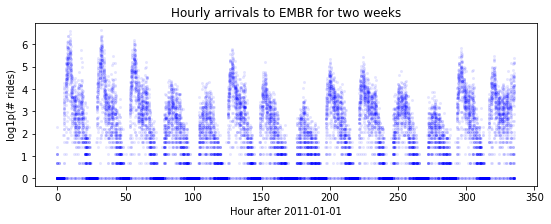

In [9]:
T, O, D = dataset["counts"].shape
data = dataset["counts"][:, :, dataset["stations"].index("EMBR")].log1p()
print(data.shape)
plt.figure(figsize=(9, 3))
plt.plot(data[-24 * 7 * 2:], 'b.', alpha=0.1, markeredgewidth=0)
plt.title("Hourly arrivals to EMBR for two weeks")
plt.ylabel("log1p(# rides)")
plt.xlabel("Hour after 2011-01-01");

In [10]:
data.shape

torch.Size([78888, 50])

In [11]:
class Model1(ForecastingModel):
    def model(self, zero_data, covariates):
        duration, data_dim = zero_data.shape

        # Let's model each time series as a Levy stable process, and share process parameters
        # across time series. To do that in Pyro, we'll declare the shared random variables
        # outside of the "origin" plate:
        drift_stability = pyro.sample("drift_stability", dist.Uniform(1, 2))
        drift_scale = pyro.sample("drift_scale", dist.LogNormal(-20, 5))
        with pyro.plate("origin", data_dim, dim=-2):
            # Now inside of the origin plate we sample drift and seasonal components.
            # All the time series inside the "origin" plate are independent,
            # given the drift parameters above.
            with self.time_plate:
                # We combine two different reparameterizers: the inner SymmetricStableReparam
                # is needed for the Stable site, and the outer LocScaleReparam is optional but
                # appears to improve inference.
                with poutine.reparam(config={"drift": LocScaleReparam()}):
                    with poutine.reparam(config={"drift": SymmetricStableReparam()}):
                        drift = pyro.sample("drift",
                                            dist.Stable(drift_stability, 0, drift_scale))

            with pyro.plate("hour_of_week", 24 * 7, dim=-1):
                seasonal = pyro.sample("seasonal", dist.Normal(0, 5))

        # Now outside of the time plate we can perform time-dependent operations like
        # integrating over time. This allows us to create a motion with slow drift.
        seasonal = periodic_repeat(seasonal, duration, dim=-1)
        motion = drift.cumsum(dim=-1)  # A Levy stable motion to model shocks.
        prediction = motion + seasonal

        # Next we do some reshaping. Pyro's forecasting framework assumes all data is
        # multivariate of shape (duration, data_dim), but the above code uses an "origins"
        # plate that is left of the time_plate. Our prediction starts off with shape
        assert prediction.shape[-2:] == (data_dim, duration)
        # We need to swap those dimensions but keep the -2 dimension intact, in case Pyro
        # adds sample dimensions to the left of that.
        prediction = prediction.unsqueeze(-1).transpose(-1, -3)
        assert prediction.shape[-3:] == (1, duration, data_dim), prediction.shape
        
        # Finally we can construct a noise distribution.
        # We will share parameters across all time series.
        obs_scale = pyro.sample("obs_scale", dist.LogNormal(-5, 5))
        noise_dist = dist.Normal(0, obs_scale.unsqueeze(-1))
        self.predict(noise_dist, prediction)

In [12]:
T2 = data.size(-2)    # end
T1 = T2 - 24 * 7 * 2  # train/test split
T0 = T1 - 24 * 90     # beginning: train on 90 days of data
covariates = torch.zeros(data.size(-2), 0)  # empty covariates

In [13]:
%%time
pyro.set_rng_seed(1)
pyro.clear_param_store()
covariates = torch.zeros(len(data), 0)  # empty
forecaster = Forecaster(Model1(), data[T0:T1], covariates[T0:T1],
                        learning_rate=0.1, num_steps=501, log_every=50)
for name, value in forecaster.guide.median().items():
    if value.numel() == 1:
        print("{} = {:0.4g}".format(name, value.item()))

INFO 	 step    0 loss = 705188
INFO 	 step   50 loss = 7.72268
INFO 	 step  100 loss = 3.44736
INFO 	 step  150 loss = 1.98428
INFO 	 step  200 loss = 1.48848
INFO 	 step  250 loss = 1.25247
INFO 	 step  300 loss = 1.18879
INFO 	 step  350 loss = 1.12254
INFO 	 step  400 loss = 1.10266
INFO 	 step  450 loss = 1.07723
INFO 	 step  500 loss = 1.05631


drift_stability = 1.997
drift_scale = 4.023e-08
obs_scale = 0.4636
CPU times: user 32.3 s, sys: 15 s, total: 47.4 s
Wall time: 24.8 s


torch.Size([100, 1, 336, 50]) torch.Size([336, 50])


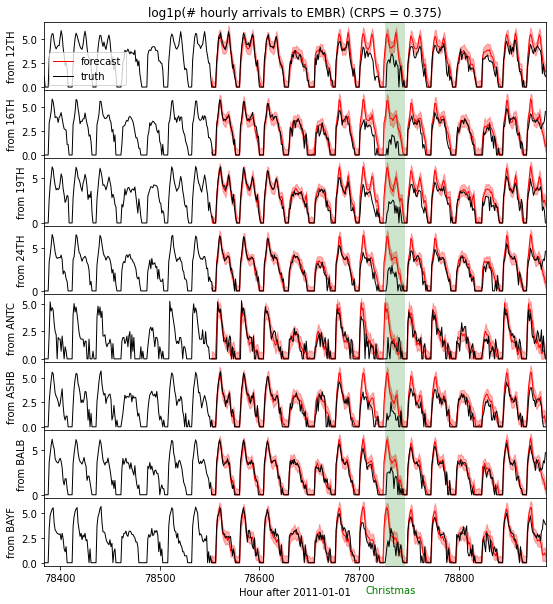

In [15]:
samples = forecaster(data[T0:T1], covariates[T0:T2], num_samples=100)
samples.clamp_(min=0)  # apply domain knowledge: the samples must be positive
p10, p50, p90 = quantile(samples[:, 0], (0.1, 0.5, 0.9)).squeeze(-1)
crps = eval_crps(samples, data[T1:T2])
print(samples.shape, p10.shape)

fig, axes = plt.subplots(8, 1, figsize=(9, 10), sharex=True)
plt.subplots_adjust(hspace=0)
axes[0].set_title("log1p(# hourly arrivals to EMBR) (CRPS = {:0.3g})".format(crps))
for i, ax in enumerate(axes):
    ax.axvline(78736, color="green", lw=20, alpha=0.2)
    ax.fill_between(torch.arange(T1, T2), p10[:, i], p90[:, i], color="red", alpha=0.3)
    ax.plot(torch.arange(T1, T2), p50[:, i], 'r-', lw=1, label='forecast')
    ax.plot(torch.arange(T1 - 24 * 7, T2),
            data[T1 - 24 * 7: T2, i], 'k-', lw=1, label='truth')
    ax.set_ylabel("from {}".format(dataset["stations"][i]))
ax.set_xlabel("Hour after 2011-01-01")
ax.text(78732, -3, "Christmas", color="green", horizontalalignment="center")
ax.set_xlim(T1 - 24 * 7, T2)
axes[0].legend(loc="best");

In [16]:
samples.size()

torch.Size([100, 1, 336, 50])

In [25]:
data = dataset["counts"].permute(1, 2, 0).unsqueeze(-1).log1p().contiguous()
print(dataset["counts"].shape, data.shape)

torch.Size([78888, 50, 50]) torch.Size([50, 50, 78888, 1])


In [26]:
class Model2(ForecastingModel):
    def model(self, zero_data, covariates):
        num_stations, num_stations, duration, one = zero_data.shape

        # We construct plates once so we can reuse them later. We ensure they don't collide by
        # specifying different dim args for each: -3, -2, -1. Note the time_plate is dim=-1.
        origin_plate = pyro.plate("origin", num_stations, dim=-3)
        destin_plate = pyro.plate("destin", num_stations, dim=-2)
        hour_of_week_plate = pyro.plate("hour_of_week", 24 * 7, dim=-1)

        # Let's model the time-dependent part with only O(num_stations * duration) many
        # parameters, rather than the full possible O(num_stations ** 2 * duration) data size.
        drift_stability = pyro.sample("drift_stability", dist.Uniform(1, 2))
        drift_scale = pyro.sample("drift_scale", dist.LogNormal(-20, 5))
        with origin_plate:
            with hour_of_week_plate:
                origin_seasonal = pyro.sample("origin_seasonal", dist.Normal(0, 5))
        with destin_plate:
            with hour_of_week_plate:
                destin_seasonal = pyro.sample("destin_seasonal", dist.Normal(0, 5))
            with self.time_plate:
                with poutine.reparam(config={"drift": LocScaleReparam()}):
                    with poutine.reparam(config={"drift": SymmetricStableReparam()}):
                        drift = pyro.sample("drift",
                                            dist.Stable(drift_stability, 0, drift_scale))
        # Additionally we can model a static pairwise station->station affinity, which e.g.
        # can compensate for the fact that people tend not to travel from a station to itself.
        with origin_plate, destin_plate:
            pairwise = pyro.sample("pairwise", dist.Normal(0, 1))

        # Outside of the time plate we can now form the prediction.
        seasonal = origin_seasonal + destin_seasonal  # Note this broadcasts.
        seasonal = periodic_repeat(seasonal, duration, dim=-1)
        motion = drift.cumsum(dim=-1)  # A Levy stable motion to model shocks.
        prediction = motion + seasonal + pairwise

        # We will decompose the noise scale parameter into
        # an origin-local and a destination-local component.
        with origin_plate:
            origin_scale = pyro.sample("origin_scale", dist.LogNormal(-5, 5))
        with destin_plate:
            destin_scale = pyro.sample("destin_scale", dist.LogNormal(-5, 5))
        scale = origin_scale + destin_scale

        # At this point our prediction and scale have shape (50, 50, duration) and (50, 50, 1)
        # respectively, but we want them to have shape (50, 50, duration, 1) to satisfy the
        # Forecaster requirements.
        scale = scale.unsqueeze(-1)
        prediction = prediction.unsqueeze(-1)

        # Finally we construct a noise distribution and call the .predict() method.
        # Note that predict must be called inside the origin and destination plates.
        noise_dist = dist.Normal(0, scale)
        with origin_plate, destin_plate:
            self.predict(noise_dist, prediction)

In [6]:
%%time
pyro.set_rng_seed(1)
pyro.clear_param_store()
covariates = torch.zeros(data.size(-2), 0)  # empty
forecaster = Forecaster(Model2(), data[..., T0:T1, :], covariates[T0:T1],
                        learning_rate=0.1, learning_rate_decay=1, num_steps=501, log_every=50)
for name, value in forecaster.guide.median().items():
    if value.numel() == 1:
        print("{} = {:0.4g}".format(name, value.item()))

NameError: name 'Model2' is not defined

In [28]:
%%time
samples = forecaster(data[..., T0:T1, :], covariates[T0:T2], num_samples=100)
samples.clamp_(min=0)  # apply domain knowledge: the samples must be positive
p10, p50, p90 = quantile(samples[..., 0], (0.1, 0.5, 0.9))
crps = eval_crps(samples, data[..., T1:T2, :])
print(samples.shape, p10.shape)

torch.Size([100, 50, 50, 336, 1]) torch.Size([50, 50, 336])
CPU times: user 17.8 s, sys: 9.94 s, total: 27.7 s
Wall time: 11.4 s


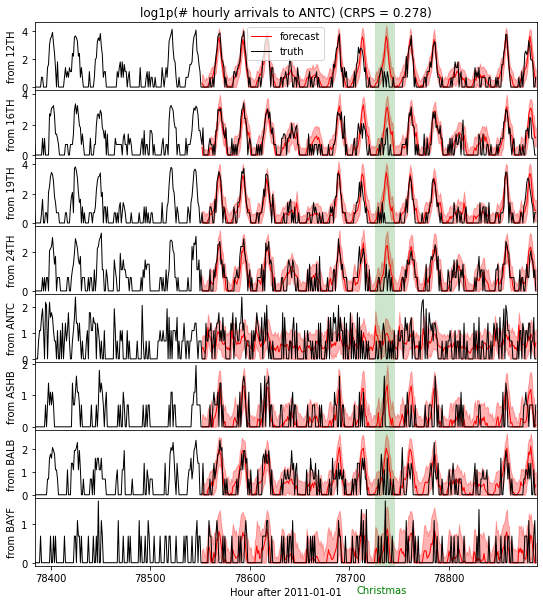

In [29]:
fig, axes = plt.subplots(8, 1, figsize=(9, 10), sharex=True)
plt.subplots_adjust(hspace=0)
j = dataset["stations"].index("ANTC")
axes[0].set_title("log1p(# hourly arrivals to ANTC) (CRPS = {:0.3g})".format(crps))
for i, ax in enumerate(axes):
    ax.axvline(78736, color="green", lw=20, alpha=0.2)
    ax.fill_between(torch.arange(T1, T2), p10[i, j], p90[i, j], color="red", alpha=0.3)
    ax.plot(torch.arange(T1, T2), p50[i, j], 'r-', lw=1, label='forecast')
    ax.plot(torch.arange(T1 - 24 * 7, T2),
            data[i, j, T1 - 24 * 7: T2, 0], 'k-', lw=1, label='truth')
    ax.set_ylabel("from {}".format(dataset["stations"][i]))
ax.set_xlabel("Hour after 2011-01-01")
ax.text(78732, -0.8, "Christmas", color="green", horizontalalignment="center")
ax.set_xlim(T1 - 24 * 7, T2)
axes[0].legend(loc="best");

In [30]:
def create_plates(zero_data, covariates):
    num_origins, num_destins, duration, one = zero_data.shape
    return [pyro.plate("origin", num_origins, subsample_size=10, dim=-3),
            pyro.plate("destin", num_destins, subsample_size=10, dim=-2)]

In [31]:
%%time
pyro.set_rng_seed(1)
pyro.clear_param_store()
covariates = torch.zeros(data.size(-2), 0)  # empty
forecaster = Forecaster(Model2(), data[..., T0:T1, :], covariates[T0:T1],
                        create_plates=create_plates,
                        learning_rate=0.1, num_steps=1201, log_every=50)
for name, value in forecaster.guide.median().items():
    if value.numel() == 1:
        print("{} = {:0.4g}".format(name, value.item()))

INFO 	 step    0 loss = 1.14288e+08
INFO 	 step   50 loss = 5.6001e+09
INFO 	 step  100 loss = 26085.5
INFO 	 step  150 loss = 89153.5
INFO 	 step  200 loss = 917781
INFO 	 step  250 loss = 2.20932
INFO 	 step  300 loss = 53.4096
INFO 	 step  350 loss = 3.99031
INFO 	 step  400 loss = 1.01544
INFO 	 step  450 loss = 0.958377
INFO 	 step  500 loss = 0.780323
INFO 	 step  550 loss = 0.785714
INFO 	 step  600 loss = 0.817635
INFO 	 step  650 loss = 0.779168
INFO 	 step  700 loss = 0.749352
INFO 	 step  750 loss = 0.709319
INFO 	 step  800 loss = 0.688472
INFO 	 step  850 loss = 0.792985
INFO 	 step  900 loss = 0.731573
INFO 	 step  950 loss = 0.779231
INFO 	 step 1000 loss = 0.639156
INFO 	 step 1050 loss = 0.623224
INFO 	 step 1100 loss = 0.693368
INFO 	 step 1150 loss = 0.577156
INFO 	 step 1200 loss = 0.791245


drift_stability = 1.631
drift_scale = 5.061e-08
CPU times: user 51.9 s, sys: 21.1 s, total: 1min 12s
Wall time: 50.8 s
